# Chapter 7 - Example: Exploratory Analysis of Saildrone Cruise Data

This script is an example of an exploratory analysis I performed on Saildrone data. The script reads in the data, calculates some new fields, and then generates graphs and maps to help examine the Saildrone data. The script is broken up into different parts and includes comments throughout to help you follow along. 



### Load Packages and Read in Data

In [1]:
#import necessary packages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import warnings 
warnings.simplefilter('ignore') 

#load map packages
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from calendar import month_abbr

In [2]:
#open .nc file with Saildrone Data
ddir = '~/shared/users/mgarciareyes/saildrone_data/'  #data 2
fn_list = 'saildrone_west_coast_survey_2019_sd1047_JPLv5.0_8dy_20210613norep_20210613_20211116.nc'
sail = xr.open_dataset(ddir + fn_list) 
sail.close()

#copy data for calculations versus graphing
sail_raw = sail.copy()

sail

<xarray.Dataset>
Dimensions:                       (time: 52)
Coordinates:
    trajectory                    float32 ...
  * time                          (time) datetime64[ns] 2019-07-23T07:12:55.8...
    ob                            (time) int64 ...
Data variables: (12/41)
    lat                           (time) float64 ...
    lon                           (time) float64 ...
    SOG_MEAN                      (time) float64 ...
    COG_MEAN                      (time) float64 ...
    HDG_MEAN                      (time) float64 ...
    ROLL_MEAN                     (time) float64 ...
    ...                            ...
    sat_lon                       (time) float64 ...
    dist_land                     (time) float64 ...
    analysed_sst                  (time) float64 ...
    analysis_error                (time) float64 ...
    mask                          (time) float64 ...
    sea_ice_fraction              (time) float64 ...
Attributes: (12/45)
    area:                      Pacific Ocean
    cdm_data_type:             Trajectory
    cdm_trajectory_variables:  trajectory
    Conventions:               CF-1.6, ACDD-1.3, COARDS
    creator_email:             support@saildrone.com
    creator_name:              Saildrone
    ...                        ...
    time_coverage_end:         2019-09-03T19:57:00Z
    time_coverage_resolution:  PT1M
    time_coverage_start:       2019-06-20T02:00:00Z
    title:                     Saildrone West Coast Survey 2019
    Westernmost_Easting:       -124.9878272
    vehicle_id:                sd1047

### Filter data and calculate a new column

In [3]:
#filter out salinity values that are less than or equal to 32
sail['SAL_CTD_MEAN']=sail.SAL_CTD_MEAN.where(sail.SAL_CTD_MEAN>=32, np.nan)

#resample the data by hour
sail = sail.resample(time="H").mean(skipna=True)

#add date column but store it as a matplotlib date format
sail['date'] = mdates.date2num(sail['time'].dt.date)

#create function for calculating windspeed
def windspeed(u, v):
    return np.sqrt((np.abs(u**2) + np.abs(v**2)))

#calculate windspeed using function
sail['wind_speed'] = windspeed(sail['UWND_MEAN'], sail['VWND_MEAN'])


#### **BONUS:** Comparing for loop to functions

Look at the time it takes to execute the function versus using the for loop.

%%timeit executes the cell several times to determine the average time it takes to run all the code.

In [4]:
%%timeit

wind_speed = []
for i in range(0,len(sail.date)):
    wind_i = np.sqrt(np.abs(sail.UWND_MEAN[i].values) + np.abs(sail.VWND_MEAN[i].values))
    wind_speed.append(wind_i)

376 ms ± 2.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%timeit

#create function for calculating windspeed
def windspeed(u, v):
    return np.sqrt((np.abs(u**2) + np.abs(v**2)))

#calculate windspeed using function
windspeed(sail['UWND_MEAN'], sail['VWND_MEAN'])


1.07 ms ± 91.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### View Windspeed throughout the Cruise

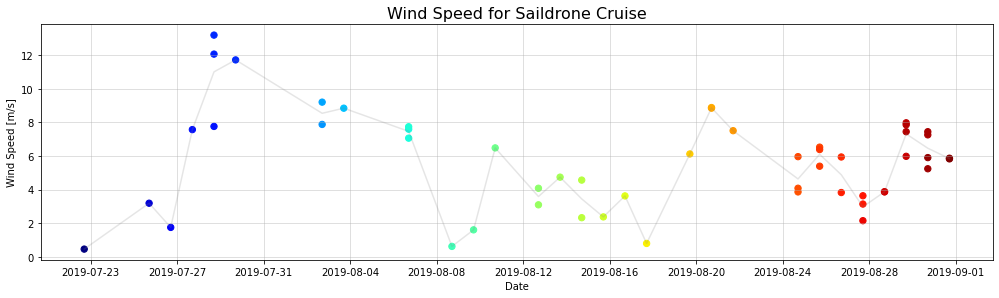

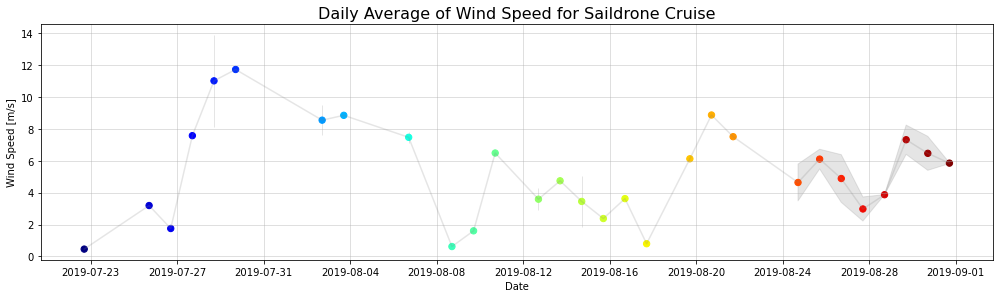

In [6]:
#resample the data by Day
resampled_wind = sail.resample(time="D", skipna = True).mean()

#create list of ticks for the x axis
default_x_ticks = range(0,len(sail['time']),divmod(len(sail['time']), 10)[0]) #selects out 10 evenly spaced dates from the data
colors = plt.cm.jet(np.linspace(0, 1, len(resampled_wind)))

#set figure size
plt.figure(figsize = (14,4))

#create lineplot 
sns.lineplot(x = sail['time'].dt.date, y = sail['wind_speed'], color = 'grey', alpha=0.2, ci=None) #seaborn has built in confidence intervals
plt.scatter(sail['time'].dt.date, sail['wind_speed'], 40, [*range(len(sail['wind_speed']))], 'o', cmap='jet') #add points for each day
plt.tight_layout()

#add labels
plt.title('Wind Speed for Saildrone Cruise', fontdict = {'fontsize' : 16}) 
plt.xlabel("Date")
plt.ylabel("Wind Speed [m/s]")

#select x axis ticks based on above values
plt.xticks(sail['time'][default_x_ticks], sail['time'].dt.date[default_x_ticks].values)
plt.grid(zorder=0, alpha=0.5)
plt.show()

#set figure size
plt.figure(figsize = (14,4))

#create lineplot 
sns.lineplot(x = sail['time'].dt.date, y = sail['wind_speed'], color = 'grey', alpha=0.2, ci='sd') #seaborn has built in confidence intervals
plt.scatter(resampled_wind['time'].dt.date, resampled_wind['wind_speed'], 40, [*range(len(resampled_wind['wind_speed']))], 'o', cmap='jet') #add points for each day
plt.tight_layout()

#add labels
plt.title('Daily Average of Wind Speed for Saildrone Cruise', fontdict = {'fontsize' : 16}) 
plt.xlabel("Date")
plt.ylabel("Wind Speed [m/s]")

#select x axis ticks based on above values
plt.xticks(sail['time'][default_x_ticks], sail['time'].dt.date[default_x_ticks].values)
plt.grid(zorder=0, alpha=0.5)
plt.show()

### View Temperature throughout the Cruise

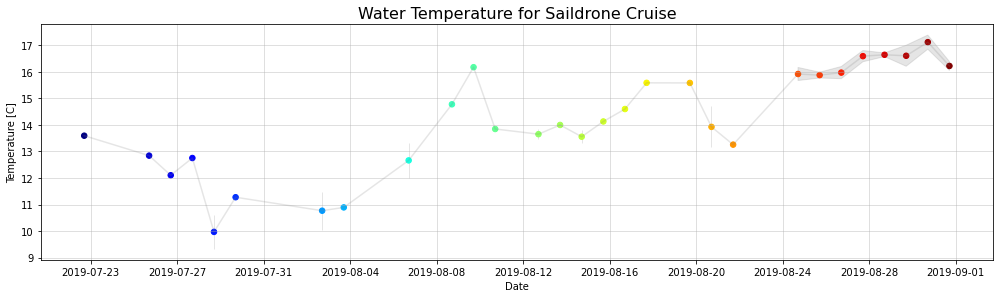

In [7]:
#resample the data by Day
resampled_temp = sail.resample(time="D", skipna = True).mean()

#set figure size
plt.figure(figsize = (14,4))

#create lineplot 
sns.lineplot(x = sail['time'].dt.date, y = sail['TEMP_CTD_MEAN'], color = 'grey', ci = 'sd', alpha=0.2)
plt.scatter(resampled_temp['time'].dt.date, resampled_temp['TEMP_CTD_MEAN'], 30, [*range(len(resampled_temp['TEMP_CTD_MEAN']))], 'o', cmap='jet')
plt.tight_layout()

#set labels
plt.title('Water Temperature for Saildrone Cruise', fontdict = {'fontsize' : 16})
plt.xlabel("Date")
plt.ylabel("Temperature [C]")

#reformat x-axis ticks
plt.xticks(sail['time'][default_x_ticks], sail['time'].dt.date[default_x_ticks].values)
plt.grid(zorder=0, alpha=0.5)
plt.show()

### View Salinity throughout the Cruise

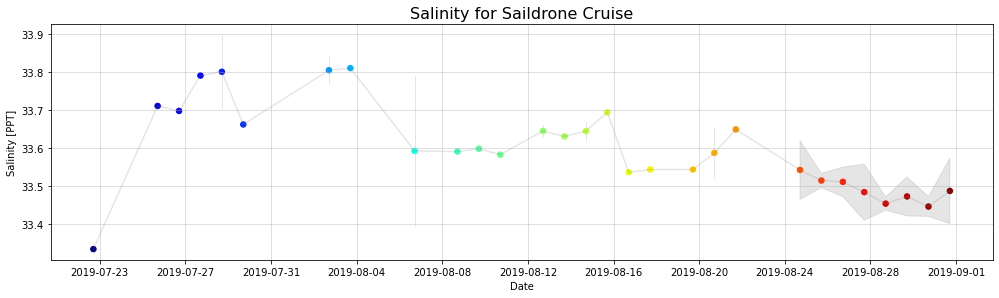

In [8]:
#resample the data by Day
resampled_sal = sail.resample(time="D", skipna = True).mean()

#set figure
plt.figure(figsize = (14,4))

#create lineplot 
sns.lineplot(x = sail['time'].dt.date, y = sail['SAL_CTD_MEAN'], color = 'grey', ci = 'sd', alpha=0.2)
plt.scatter(resampled_sal['time'].dt.date, resampled_sal['SAL_CTD_MEAN'], 30, [*range(len(resampled_sal['SAL_CTD_MEAN']))], 'o', cmap='jet')
plt.tight_layout()

#label graph
plt.title('Salinity for Saildrone Cruise', fontdict = {'fontsize' : 16})
plt.xlabel("Date")
plt.ylabel("Salinity [PPT]")

#reformat ticks
plt.xticks(sail['time'][default_x_ticks], sail['time'].dt.date[default_x_ticks].values)
plt.grid(zorder=0, alpha=0.5)
plt.show()

### Look at Sampling Tracks

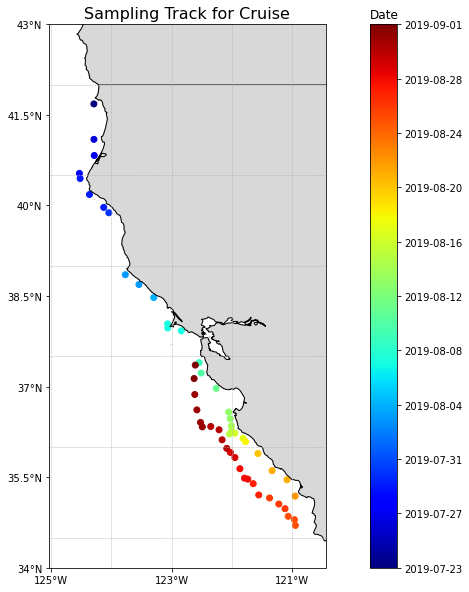

In [9]:
#define latitude and longitude boundaries
latr = [min(sail['lat']), max(sail['lat'])] 
lonr = [max(sail['lon']), min(sail['lon'])] 

# Select a region of our data, giving it a margin
margin = 0.5 
region = np.array([[latr[0]-margin,latr[1]+margin],[lonr[0]+margin,lonr[1]-margin]]) 

#add state outlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

# Create and set the figure context
fig = plt.figure(figsize=(16,10), dpi = 72) 
ax = plt.axes(projection=ccrs.PlateCarree()) 
ax.coastlines(resolution='10m',linewidth=1,color='black') 
ax.add_feature(cfeature.LAND, color='grey', alpha=0.3)
ax.add_feature(states_provinces, linewidth = 0.5)
ax.add_feature(cfeature.BORDERS)
ax.set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree()) 
ax.set_xticks(np.round([*np.arange(region[1,1],region[1,0]+1,2)][::-1],0), crs=ccrs.PlateCarree()) 
ax.set_yticks(np.round([*np.arange(np.floor(region[0,0]),region[0,1]+1,1.5)],1), crs=ccrs.PlateCarree()) 
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(linestyle = '--', linewidth = 0.5)

# Plot track data, color by temperature
loc = mdates.AutoDateLocator()
sc = plt.scatter(x = sail['lon'], y = sail['lat'], c = sail['date'], cmap='jet')
#plt.plot(sail['lon'], sail['lat'], ls = ':', c = 'navy', alpha = 0.4)
clb = fig.colorbar(sc, ticks=loc, format=mdates.AutoDateFormatter(loc))
clb.ax.set_title('Date')
clb.set_ticks(sail['date'][default_x_ticks])
clb.set_ticklabels(sail['time'].dt.date[default_x_ticks].values)
plt.title('Sampling Track for Cruise', fontdict = {'fontsize' : 16})
plt.show()

### Salinity versus Temperature Diagram

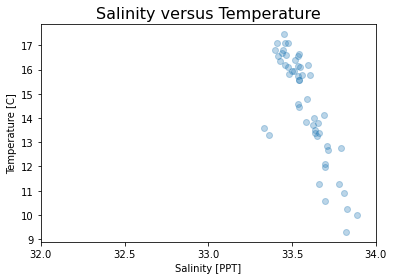

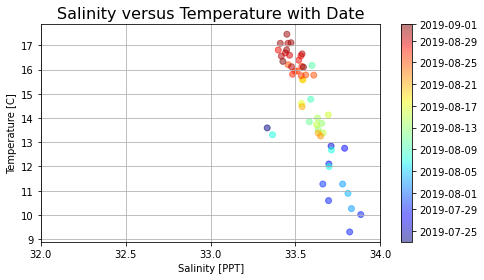

In [10]:
#filter data
sail_filtered = sail.drop('date')
sail_filtered = sail_filtered.to_dataframe()
sail_filtered['date'] = mdates.date2num(sail['time'].dt.date)
#sail_filtered.reset_index(inplace=True)
#sail_filtered['date'] = sail_filtered['time'].dt.date
sail_filtered = sail_filtered.loc[(sail_filtered['SAL_CTD_MEAN'] >= 32) & (sail_filtered['TEMP_CTD_MEAN'] >= 6), 
                                  ['date','SAL_CTD_MEAN','TEMP_CTD_MEAN','lat','lon']]

#specify salinity values
xaxis_val = [32, 32.5, 33, 33.5, 34]

#visualize temp and salinity data
fig = plt.figure() 
ax = plt.axes() 
plt.scatter(sail_filtered['SAL_CTD_MEAN'], sail_filtered['TEMP_CTD_MEAN'], alpha = 0.3)
plt.title('Salinity versus Temperature', fontdict = {'fontsize' : 16})
plt.xlabel("Salinity [PPT]") 
plt.ylabel("Temperature [C]")
plt.xticks(xaxis_val)
plt.show()

#visualize temp and salinity data with date
fig = plt.figure(figsize=(7.6,4)) 
loc = mdates.AutoDateLocator()
sc = plt.scatter(x = sail_filtered['SAL_CTD_MEAN'], y = sail_filtered['TEMP_CTD_MEAN'], c = sail_filtered['date'], cmap='jet', alpha = 0.5)
clb = fig.colorbar(sc, ticks=loc, format=mdates.AutoDateFormatter(loc))
#ax.set_label('Date')
plt.title('Salinity versus Temperature with Date', fontdict = {'fontsize' : 16})
plt.xlabel("Salinity [PPT]")
plt.ylabel("Temperature [C]")
plt.xticks(xaxis_val)
plt.grid()
plt.show()



### Temperature Values throughout the Cruise

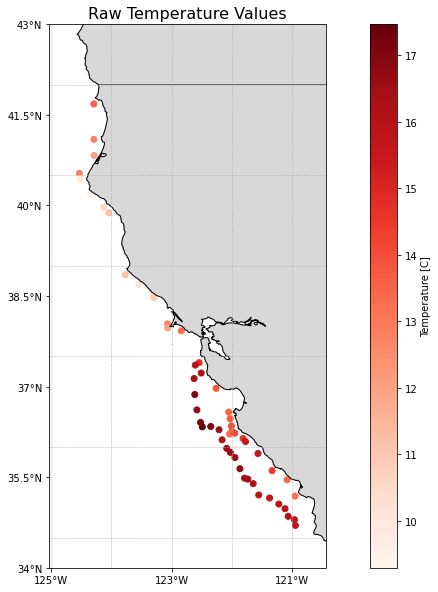

In [11]:
#define latitude and longitude boundaries
latr = [min(sail['lat']), max(sail['lat'])] 
lonr = [max(sail['lon']), min(sail['lon'])] 

# Select a region of our data, giving it a margin
margin = 0.5 
region = np.array([[latr[0]-margin,latr[1]+margin],[lonr[0]+margin,lonr[1]-margin]]) 

#add state outlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

# Create and set the figure context
fig = plt.figure(figsize=(16,10), dpi = 72) 
ax = plt.axes(projection=ccrs.PlateCarree()) 
ax.coastlines(resolution='10m',linewidth=1,color='black') 
ax.add_feature(cfeature.LAND, color='grey', alpha=0.3)
ax.add_feature(states_provinces, linewidth = 0.5)
ax.add_feature(cfeature.BORDERS)
ax.set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree()) 
ax.set_xticks(np.round([*np.arange(region[1,1],region[1,0]+1,2)][::-1],0), crs=ccrs.PlateCarree()) 
ax.set_yticks(np.round([*np.arange(np.floor(region[0,0]),region[0,1]+1,1.5)],1), crs=ccrs.PlateCarree()) 
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(linestyle = '--', linewidth = 0.5)

# Plot track data, color by temperature
sc = plt.scatter(data = sail_filtered, x = 'lon', y = 'lat', c = 'TEMP_CTD_MEAN')
clb = fig.colorbar(sc, label = "Temperature [C]")
plt.set_cmap('Reds')
plt.title('Raw Temperature Values', fontdict = {'fontsize' : 16})
plt.show()

### Salinity Values throughout the Cruise

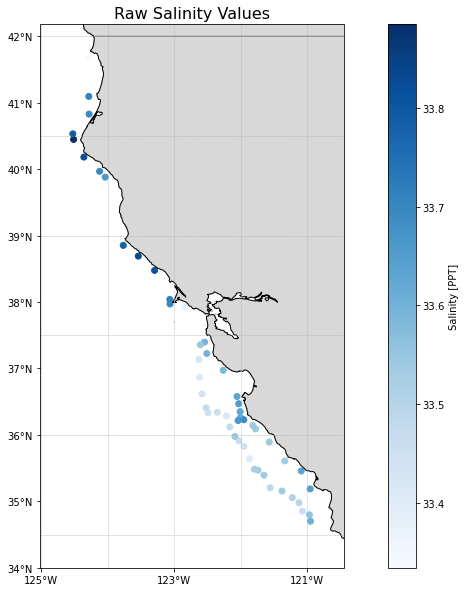

In [12]:
#define latitude and longitude boundaries
latr = [min(sail['lat']), max(sail['lat'])] 
lonr = [max(sail['lon']), min(sail['lon'])] 

# Select a region of our data, giving it a margin
margin = 0.5 
region = np.array([[latr[0]-margin,latr[1]+margin],[lonr[0]+margin,lonr[1]-margin]]) 

#add state outlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

# Create and set the figure context
fig = plt.figure(figsize=(16,10), dpi = 72) 
ax = plt.axes(projection=ccrs.PlateCarree()) 
ax.coastlines(resolution='10m',linewidth=1,color='black') 
ax.add_feature(cfeature.LAND, color='grey', alpha=0.3)
ax.add_feature(states_provinces, linewidth = 0.5)
ax.add_feature(cfeature.BORDERS)
ax.set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree()) 
ax.set_xticks(np.round([*np.arange(region[1,1],region[1,0]+1,2)][::-1],0), crs=ccrs.PlateCarree()) 
ax.set_yticks(np.round([*np.arange(region[0,0],region[0,1]+1,1)],0), crs=ccrs.PlateCarree()) 
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(linestyle = '--', linewidth = 0.5)


# Plot track data, color by temperature
sc = plt.scatter(x = sail_filtered['lon'], y = sail_filtered['lat'], c = sail_filtered['SAL_CTD_MEAN'])
clb = fig.colorbar(sc, label = "Salinity [PPT]")
plt.set_cmap('Blues')
plt.title('Raw Salinity Values', fontdict = {'fontsize' : 16})
plt.show()

## *Optional*

Run the whole script on the other saildrone data file in the data folder and see how the graphs change.

File name: saildrone_west_coast_survey_2018_sd1027jplv05.0_orbital.nc